# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 901kB 16.0MB/s 
     |████████████████████████████████| 1.2MB 28.0MB/s 
     |████████████████████████████████| 2.1MB 47.4MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 133kB 56.1MB/s 
     |████████████████████████████████| 163kB 55.3MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=212a735744a83e664a8c61bbe9e96f92992aa75d693f3da68a3958f31a7bd41c
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=33b8ea417381c70b26795fa6187a21475f655557fc1fed014df07a24766d6828
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subp

In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 27710, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 27710 (delta 60), reused 99 (delta 54), pack-reused 27579
Receiving objects: 100% (27710/27710), 11.54 MiB | 26.32 MiB/s, done.
Resolving deltas: 100% (20879/20879), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... don

In [ ]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [ ]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [ ]:
#!apt-get install megatools

## 下載檔案並解壓縮

In [ ]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

--2021-04-25 03:51:57--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yva8og.dm.files.1drv.com/y4mDrkRDpuhsZ745bnULE1kv8VPGnRBt1ywRCz8WV1aFJGd_aDF4HJ4ZA99-63U5Q2zmHD5egbdjg07KPRLZtcfyyaVn6tW0emjiAqkXkMPp72Sse9QNaSw5BtzMWkyE9eccmi_Nj-R7kdsXomDJtN56MONSj-NfNXl9P7Xr8lBRhvFF926ha0tbLIRbg7bFxPEePgcSDMTybwkXaCU1AsHRQ/ted2020.tgz?download&psid=1 [following]
--2021-04-25 03:51:58--  https://yva8og.dm.files.1drv.com/y4mDrkRDpuhsZ745bnULE1kv8VPGnRBt1ywRCz8WV1aFJGd_aDF4HJ4ZA99-63U5Q2zmHD5egbdjg07KPRLZtcfyyaVn6tW0emjiAqkXkMPp72Sse9QNaSw5BtzMWkyE9eccmi_Nj-R7kdsXomDJtN56MONSj-NfNXl9P7Xr8lBRhvFF926ha0tbLIRbg7bFxPEePgcSDMTybwkXaCU1AsHRQ/ted2020.tgz?download&psid=1
Resolving yva8og.dm.files.1drv.com (yva8og.dm.files.1drv.com).

In [ ]:
prefix

PosixPath('/content/DATA/rawdata/ted2020')

## 設定語言

In [ ]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [ ]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [ ]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [ ]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [ ]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [ ]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !


## 用 fairseq 將資料轉為 binary

In [ ]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2021-04-25 03:56:55 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

# 實驗的參數設定表

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [ ]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [ ]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-25 03:59:41 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-25 03:59:41 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 14.756 GB ; name = Tesla T4                                
2021-04-25 03:59:41 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-25 03:59:41 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-25 03:59:41 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-25 03:59:41 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-25 03:59:41 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-04-25 03:59:41 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-04-25 03:59:41 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2021-04-25 03:59:41 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-04-25 03:59:41 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-04-25 03:59:41 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2]),
 'target': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-25 03:59:41 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 2444, 135, 3058, 93, 2275, 682, 2649, 731, 1623]


{'id': tensor([3200,  828]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,  237, 1769,    9,  494,  491,  670,    4,   10,    1,    1,
              1,    1,    1,    1],
          [   2,    4,  325, 1974,  793,  294,  289,  596,    4,   10,    1,    1,
              1,    1,    1,    1]]),
  'src_lengths': tensor([8, 8]),
  'src_tokens': tensor([[ 159, 2479,   17,  131,   72,  733,    7,    2],
          [  81,    4, 1709,    4,  862,  718,    7,    2]])},
 'nsentences': 2,
 'ntokens': 20,
 'target': tensor([[   4,  237, 1769,    9,  494,  491,  670,    4,   10,    2,    1,    1,
             1,    1,    1,    1],
         [   4,  325, 1974,  793,  294,  289,  596,    4,   10,    2,    1,    1,
             1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [ ]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [ ]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [ ]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [ ]:
# # HINT: transformer 架構
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [ ]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

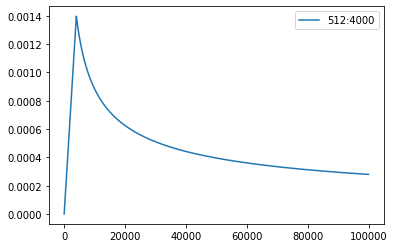

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [ ]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [ ]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [ ]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [ ]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
!nvidia-smi

Sun Apr 25 04:39:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   1258MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-25 03:59:55 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-25 03:59:55 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-25 03:59:55 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-25 03:59:55 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-25 03:59:55 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-25 03:59:55 | INFO | hw5.seq2seq | num. model params: 52,332,544 (num. trained: 52,332,544)
2021-04-25 03:59:55 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-20 10:23:13 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-20 10:23:13 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!


2021-04-20 10:28:09 | INFO | hw5.seq2seq | training loss: 6.9036
2021-04-20 10:28:09 | INFO | hw5.seq2seq | begin validation


2021-04-20 10:28:44 | INFO | hw5.seq2seq | example source: right , it's gone ? or is it still up there ?
2021-04-20 10:28:44 | INFO | hw5.seq2seq | example hypothesis: 今天 , 說 , 說: 「 說: 「 說: 「 ?
2021-04-20 10:28:44 | INFO | hw5.seq2seq | example reference: 還是還在 ?
2021-04-20 10:28:44 | INFO | hw5.seq2seq | validation loss:	5.7415
2021-04-20 10:28:44 | INFO | hw5.seq2seq | BLEU = 1.01 17.4/2.9/0.5/0.1 (BP = 0.825 ratio = 0.839 hyp_len = 93793 ref_len = 111811)
2021-04-20 10:28:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint1.pt
2021-04-20 10:28:44 | INFO | hw5.seq2seq | end of epoch 1


2021-04-20 10:33:39 | INFO | hw5.seq2seq | training loss: 5.3198
2021-04-20 10:33:39 | INFO | hw5.seq2seq | begin validation


2021-04-20 10:34:13 | INFO | hw5.seq2seq | example source: it's a ways out still .
2021-04-20 10:34:13 | INFO | hw5.seq2seq | example hypothesis: 它仍然是一種方法 。
2021-04-20 10:34:13 | INFO | hw5.seq2seq | example reference: 這計畫目前還在進行 。
2021-04-20 10:34:13 | INFO | hw5.seq2seq | validation loss:	4.7358
2021-04-20 10:34:13 | INFO | hw5.seq2seq | BLEU = 8.52 38.0/14.7/6.2/2.7 (BP = 0.866 ratio = 0.874 hyp_len = 97733 ref_len = 111811)
2021-04-20 10:34:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint2.pt
2021-04-20 10:34:13 | INFO | hw5.seq2seq | end of epoch 2


2021-04-20 10:39:07 | INFO | hw5.seq2seq | training loss: 4.7218
2021-04-20 10:39:07 | INFO | hw5.seq2seq | begin validation


2021-04-20 10:39:41 | INFO | hw5.seq2seq | example source: fear not .
2021-04-20 10:39:41 | INFO | hw5.seq2seq | example hypothesis: 恐懼不是恐懼 。
2021-04-20 10:39:41 | INFO | hw5.seq2seq | example reference: 別怕 。
2021-04-20 10:39:41 | INFO | hw5.seq2seq | validation loss:	4.3720
2021-04-20 10:39:41 | INFO | hw5.seq2seq | BLEU = 11.77 43.5/19.4/9.3/4.6 (BP = 0.853 ratio = 0.863 hyp_len = 96499 ref_len = 111811)
2021-04-20 10:39:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint3.pt
2021-04-20 10:39:41 | INFO | hw5.seq2seq | end of epoch 3


2021-04-20 10:44:38 | INFO | hw5.seq2seq | training loss: 4.4154
2021-04-20 10:44:38 | INFO | hw5.seq2seq | begin validation


2021-04-20 10:45:11 | INFO | hw5.seq2seq | example source: and we had we zoned it , you know: we put a nightclub , we put a disco where you could dance , and then we had a place where you could fight with guns if you wanted to , and we had another place that was like a boardwalk , kind of a coney island .
2021-04-20 10:45:11 | INFO | hw5.seq2seq | example hypothesis: 我們有了它 , 你知道嗎 ? 我們放個夜晚餐 , 我們放了一夜晚餐 , 在那裡 , 然後我們有一個地方可以和槍擊 , 然後我們有另一個地方 , 而如果你想 , 我們有另一個地方 , 我們有另一個地方 。
2021-04-20 10:45:11 | INFO | hw5.seq2seq | example reference: 我們還規劃了夜店並且放了讓大家可以跳舞的迪斯可另外還有一個可以讓你和別人拿槍單挑的地方還有另一個地方有著又長又寬的走道 , 有點像是康尼島
2021-04-20 10:45:11 | INFO | hw5.seq2seq | validation loss:	4.0850
2021-04-20 10:45:11 | INFO | hw5.seq2seq | BLEU = 14.88 48.6/23.2/12.0/6.5 (BP = 0.865 ratio = 0.874 hyp_len = 97679 ref_len = 111811)
2021-04-20 10:45:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint4.pt
2021-04-20 10:45:11 | INFO | hw5.seq2seq | end of epoch 4


2021-04-20 10:50:06 | INFO | hw5.seq2seq | training loss: 4.2148
2021-04-20 10:50:06 | INFO | hw5.seq2seq | begin validation


2021-04-20 10:50:40 | INFO | hw5.seq2seq | example source: and there is no statistical difference between the white parents and the black parents .
2021-04-20 10:50:40 | INFO | hw5.seq2seq | example hypothesis: 白人父母和黑人父母之間沒有統計差別 。
2021-04-20 10:50:40 | INFO | hw5.seq2seq | example reference: 在白人父母和黑人父母之間 , 也沒有什麼差別 ,
2021-04-20 10:50:40 | INFO | hw5.seq2seq | validation loss:	3.9439
2021-04-20 10:50:40 | INFO | hw5.seq2seq | BLEU = 17.49 49.0/24.3/12.7/7.0 (BP = 0.969 ratio = 0.969 hyp_len = 108368 ref_len = 111811)
2021-04-20 10:50:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint5.pt
2021-04-20 10:50:41 | INFO | hw5.seq2seq | end of epoch 5


2021-04-20 10:55:36 | INFO | hw5.seq2seq | training loss: 4.0685
2021-04-20 10:55:36 | INFO | hw5.seq2seq | begin validation


2021-04-20 10:56:07 | INFO | hw5.seq2seq | example source: we have to end this .
2021-04-20 10:56:07 | INFO | hw5.seq2seq | example hypothesis: 我們必須結束 。
2021-04-20 10:56:07 | INFO | hw5.seq2seq | example reference: 我們必須要終結這種事 。
2021-04-20 10:56:07 | INFO | hw5.seq2seq | validation loss:	3.7891
2021-04-20 10:56:07 | INFO | hw5.seq2seq | BLEU = 18.39 53.4/27.3/14.9/8.5 (BP = 0.888 ratio = 0.894 hyp_len = 99950 ref_len = 111811)
2021-04-20 10:56:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint6.pt
2021-04-20 10:56:08 | INFO | hw5.seq2seq | end of epoch 6


2021-04-20 11:01:03 | INFO | hw5.seq2seq | training loss: 3.9361
2021-04-20 11:01:03 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:01:36 | INFO | hw5.seq2seq | example source: question for you , though .
2021-04-20 11:01:36 | INFO | hw5.seq2seq | example hypothesis: 但對你來說 , 問題是 。
2021-04-20 11:01:36 | INFO | hw5.seq2seq | example reference: 但 , 有問題想請教 。
2021-04-20 11:01:36 | INFO | hw5.seq2seq | validation loss:	3.7096
2021-04-20 11:01:36 | INFO | hw5.seq2seq | BLEU = 19.95 52.6/27.3/14.9/8.6 (BP = 0.963 ratio = 0.963 hyp_len = 107705 ref_len = 111811)
2021-04-20 11:01:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint7.pt
2021-04-20 11:01:37 | INFO | hw5.seq2seq | end of epoch 7


2021-04-20 11:06:30 | INFO | hw5.seq2seq | training loss: 3.8428
2021-04-20 11:06:30 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:07:01 | INFO | hw5.seq2seq | example source: yes , we are 97 percent less likely to be killed by a bolt of lightning .
2021-04-20 11:07:01 | INFO | hw5.seq2seq | example hypothesis: 是的 , 我們有97%的可能性被燈光殺死 。
2021-04-20 11:07:01 | INFO | hw5.seq2seq | example reference: 是的 , 我們被閃電打中而死的機率也一樣減少了97% 。
2021-04-20 11:07:01 | INFO | hw5.seq2seq | validation loss:	3.6323
2021-04-20 11:07:01 | INFO | hw5.seq2seq | BLEU = 20.30 55.2/29.1/16.2/9.5 (BP = 0.913 ratio = 0.916 hyp_len = 102436 ref_len = 111811)
2021-04-20 11:07:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint8.pt
2021-04-20 11:07:01 | INFO | hw5.seq2seq | end of epoch 8


2021-04-20 11:11:56 | INFO | hw5.seq2seq | training loss: 3.7776
2021-04-20 11:11:56 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:12:25 | INFO | hw5.seq2seq | example source: you know ?
2021-04-20 11:12:25 | INFO | hw5.seq2seq | example hypothesis: 你知道嗎 ?
2021-04-20 11:12:25 | INFO | hw5.seq2seq | example reference: 你知道嗎 ?
2021-04-20 11:12:25 | INFO | hw5.seq2seq | validation loss:	3.5957
2021-04-20 11:12:25 | INFO | hw5.seq2seq | BLEU = 20.63 56.8/30.3/17.1/10.2 (BP = 0.882 ratio = 0.888 hyp_len = 99295 ref_len = 111811)
2021-04-20 11:12:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint9.pt
2021-04-20 11:12:26 | INFO | hw5.seq2seq | end of epoch 9


2021-04-20 11:17:21 | INFO | hw5.seq2seq | training loss: 3.7251
2021-04-20 11:17:21 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:17:52 | INFO | hw5.seq2seq | example source: i would spend hours looking at the connections , saying , " oh , the little kid up at the top has red hair ; so does that first generation up there . "
2021-04-20 11:17:52 | INFO | hw5.seq2seq | example hypothesis: 我花了好幾個小時看著聯繫 , 說: 「 喔 , 頂端的小孩子有紅髮 ; 所以 , 第一代就在那兒 。 」
2021-04-20 11:17:52 | INFO | hw5.seq2seq | example reference: 盯著它好幾個鐘頭 , 找出其中的關聯 「 喔 ! 最上面那個小孩頭髮是紅的 」 「 他的第一代祖先也是紅頭髮耶 ! 」
2021-04-20 11:17:52 | INFO | hw5.seq2seq | validation loss:	3.5493
2021-04-20 11:17:52 | INFO | hw5.seq2seq | BLEU = 21.98 55.4/29.8/16.9/10.1 (BP = 0.953 ratio = 0.954 hyp_len = 106682 ref_len = 111811)
2021-04-20 11:17:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint10.pt
2021-04-20 11:17:53 | INFO | hw5.seq2seq | end of epoch 10


2021-04-20 11:22:49 | INFO | hw5.seq2seq | training loss: 3.6867
2021-04-20 11:22:49 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:23:17 | INFO | hw5.seq2seq | example source: humans don't learn by being told what they see , but by learning for themselves what these things are .
2021-04-20 11:23:17 | INFO | hw5.seq2seq | example hypothesis: 人類從未被告知 , 但透過學習自己所見的東西 , 學習這些東西是什麼 。
2021-04-20 11:23:17 | INFO | hw5.seq2seq | example reference: 人類並非通過別人的指示來學習 , 而是從自己搞懂事情來學習 。
2021-04-20 11:23:17 | INFO | hw5.seq2seq | validation loss:	3.5224
2021-04-20 11:23:17 | INFO | hw5.seq2seq | BLEU = 21.74 56.7/30.6/17.4/10.4 (BP = 0.918 ratio = 0.921 hyp_len = 102985 ref_len = 111811)
2021-04-20 11:23:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint11.pt
2021-04-20 11:23:18 | INFO | hw5.seq2seq | end of epoch 11


2021-04-20 11:28:13 | INFO | hw5.seq2seq | training loss: 3.6491
2021-04-20 11:28:13 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:28:44 | INFO | hw5.seq2seq | example source: they did this because this was common practice in medicine , even though it was obvious that this was not a good idea .
2021-04-20 11:28:44 | INFO | hw5.seq2seq | example hypothesis: 他們這麼做是因為這在醫學上是常見的練習雖然很明顯 , 這並不是個好主意
2021-04-20 11:28:44 | INFO | hw5.seq2seq | example reference: 他們這樣做 , 是因為醫學上這是通常的手續 , 即使很明顯的 , 並不是個好主意 。
2021-04-20 11:28:44 | INFO | hw5.seq2seq | validation loss:	3.5034
2021-04-20 11:28:44 | INFO | hw5.seq2seq | BLEU = 21.92 57.7/31.5/18.1/10.9 (BP = 0.897 ratio = 0.902 hyp_len = 100803 ref_len = 111811)
2021-04-20 11:28:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint12.pt
2021-04-20 11:28:44 | INFO | hw5.seq2seq | end of epoch 12


2021-04-20 11:33:38 | INFO | hw5.seq2seq | training loss: 3.6227
2021-04-20 11:33:38 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:34:09 | INFO | hw5.seq2seq | example source: and think about what a gift it would be for our children to be able to wake up naturally , in harmony with their own biology .
2021-04-20 11:34:09 | INFO | hw5.seq2seq | example hypothesis: 想想看 , 給孩子們什麼禮物 , 自然地醒來 , 在和他們自己的生物學中 。
2021-04-20 11:34:09 | INFO | hw5.seq2seq | example reference: 也想像一下 , 如果我們的孩子能夠睡到自然醒 , 與他們自己的生理時鐘一致 , 這將會是多麼珍貴的禮物 。
2021-04-20 11:34:09 | INFO | hw5.seq2seq | validation loss:	3.4821
2021-04-20 11:34:09 | INFO | hw5.seq2seq | BLEU = 22.28 58.3/32.0/18.4/11.1 (BP = 0.898 ratio = 0.902 hyp_len = 100900 ref_len = 111811)
2021-04-20 11:34:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint13.pt
2021-04-20 11:34:09 | INFO | hw5.seq2seq | end of epoch 13


2021-04-20 11:39:07 | INFO | hw5.seq2seq | training loss: 3.5977
2021-04-20 11:39:07 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:39:38 | INFO | hw5.seq2seq | example source: and the upshot of all of that is that i actually feel a lot happier , healthier , more productive than i ever have .
2021-04-20 11:39:38 | INFO | hw5.seq2seq | example hypothesis: 而這一切的最底層 , 就是我覺得我比起從來更快樂、更健康、更有生產力 。
2021-04-20 11:39:38 | INFO | hw5.seq2seq | example reference: 這全部的結論是我真的比以往更感到充滿快樂 , 健康 , 更有生產力 。
2021-04-20 11:39:38 | INFO | hw5.seq2seq | validation loss:	3.4625
2021-04-20 11:39:38 | INFO | hw5.seq2seq | BLEU = 22.62 57.5/31.5/18.1/10.9 (BP = 0.924 ratio = 0.927 hyp_len = 103655 ref_len = 111811)
2021-04-20 11:39:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint14.pt
2021-04-20 11:39:38 | INFO | hw5.seq2seq | end of epoch 14


2021-04-20 11:44:40 | INFO | hw5.seq2seq | training loss: 3.5776
2021-04-20 11:44:40 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:45:10 | INFO | hw5.seq2seq | example source: of course , there was another kind of sacrifice involving his family that i understood much later .
2021-04-20 11:45:10 | INFO | hw5.seq2seq | example hypothesis: 當然 , 還有另一種犧牲讓我更晚了解他的家人 。
2021-04-20 11:45:10 | INFO | hw5.seq2seq | example reference: 還有一種代價少不了的就是犧牲他的家庭 , 這我後來才明白
2021-04-20 11:45:10 | INFO | hw5.seq2seq | validation loss:	3.4451
2021-04-20 11:45:10 | INFO | hw5.seq2seq | BLEU = 22.42 58.7/32.4/18.7/11.3 (BP = 0.890 ratio = 0.896 hyp_len = 100146 ref_len = 111811)
2021-04-20 11:45:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint15.pt
2021-04-20 11:45:10 | INFO | hw5.seq2seq | end of epoch 15


2021-04-20 11:50:13 | INFO | hw5.seq2seq | training loss: 3.5552
2021-04-20 11:50:13 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:50:44 | INFO | hw5.seq2seq | example source: it is vital that the ideas that are nurtured in ted , that the ideas that we think about look forward , and make sure that this will be the most glorious century , and not one of ecodisaster and ecocollapse .
2021-04-20 11:50:44 | INFO | hw5.seq2seq | example hypothesis: 重要的是 , 在ted培養出的點子 , 是我們要向前探索的想法 , 確保這將會是最魅惑的世紀 , 而不是生態災害和生態系統 。
2021-04-20 11:50:44 | INFO | hw5.seq2seq | example reference: 眾多講者在ted分享的想法我們自己腦袋裡的想法都是期盼盼望21世紀是光榮盛世而不是生靈塗炭的黑暗世紀
2021-04-20 11:50:44 | INFO | hw5.seq2seq | validation loss:	3.4301
2021-04-20 11:50:44 | INFO | hw5.seq2seq | BLEU = 22.84 58.0/31.9/18.4/11.2 (BP = 0.919 ratio = 0.922 hyp_len = 103120 ref_len = 111811)
2021-04-20 11:50:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint16.pt
2021-04-20 11:50:45 | INFO | hw5.seq2seq | end of epoch 16


2021-04-20 11:55:45 | INFO | hw5.seq2seq | training loss: 3.5375
2021-04-20 11:55:45 | INFO | hw5.seq2seq | begin validation


2021-04-20 11:56:17 | INFO | hw5.seq2seq | example source: that this supported something integral to who i was .
2021-04-20 11:56:17 | INFO | hw5.seq2seq | example hypothesis: 這支援了我所屬的對象 。
2021-04-20 11:56:17 | INFO | hw5.seq2seq | example reference: 而是這件事讓我可以成為我自己 。
2021-04-20 11:56:17 | INFO | hw5.seq2seq | validation loss:	3.4180
2021-04-20 11:56:17 | INFO | hw5.seq2seq | BLEU = 23.00 57.7/31.9/18.3/11.0 (BP = 0.931 ratio = 0.934 hyp_len = 104390 ref_len = 111811)
2021-04-20 11:56:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint17.pt
2021-04-20 11:56:17 | INFO | hw5.seq2seq | end of epoch 17


2021-04-20 12:01:20 | INFO | hw5.seq2seq | training loss: 3.5204
2021-04-20 12:01:20 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:01:50 | INFO | hw5.seq2seq | example source: these are not dying peoples .
2021-04-20 12:01:50 | INFO | hw5.seq2seq | example hypothesis: 這些不是死人 。
2021-04-20 12:01:50 | INFO | hw5.seq2seq | example reference: 他們並不是垂死掙扎的人們 。
2021-04-20 12:01:50 | INFO | hw5.seq2seq | validation loss:	3.4237
2021-04-20 12:01:50 | INFO | hw5.seq2seq | BLEU = 22.21 58.8/32.4/18.7/11.3 (BP = 0.883 ratio = 0.889 hyp_len = 99418 ref_len = 111811)
2021-04-20 12:01:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint18.pt
2021-04-20 12:01:51 | INFO | hw5.seq2seq | end of epoch 18


2021-04-20 12:06:52 | INFO | hw5.seq2seq | training loss: 3.5108
2021-04-20 12:06:52 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:07:24 | INFO | hw5.seq2seq | example source: and additional elements hidden throughout the frame offer even more secrets for close observers .
2021-04-20 12:07:24 | INFO | hw5.seq2seq | example hypothesis: 此外 , 隱藏在整個框架中 , 提供更多秘密 , 來接近觀察者 。
2021-04-20 12:07:24 | INFO | hw5.seq2seq | example reference: 在畫中各處隱藏的額外元素帶給仔細觀賞的觀者更多的秘密 。
2021-04-20 12:07:24 | INFO | hw5.seq2seq | validation loss:	3.4105
2021-04-20 12:07:24 | INFO | hw5.seq2seq | BLEU = 23.15 58.0/32.1/18.6/11.3 (BP = 0.927 ratio = 0.929 hyp_len = 103903 ref_len = 111811)
2021-04-20 12:07:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint19.pt
2021-04-20 12:07:24 | INFO | hw5.seq2seq | end of epoch 19


2021-04-20 12:12:25 | INFO | hw5.seq2seq | training loss: 3.4966
2021-04-20 12:12:25 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:12:58 | INFO | hw5.seq2seq | example source: it's obviously also about taking responsibility , like i did here when throwing some green dye in the river in l . a . , stockholm , norway and tokyo , among other places .
2021-04-20 12:12:58 | INFO | hw5.seq2seq | example hypothesis: 很顯然 , 我也要負起責任 , 就像我在這裡一樣 , 在洛杉磯 , 諾威爾姆和東京 , 在其他地方丟了一些綠色染料 。
2021-04-20 12:12:58 | INFO | hw5.seq2seq | example reference: 它是那麼樣的顯而易見的 , 就像我需要負起我所做的事情的責任一般 , 我曾在河流之中投下綠色的染料像是洛杉磯、斯德哥爾摩、挪威與東京等諸多地方 。
2021-04-20 12:12:58 | INFO | hw5.seq2seq | validation loss:	3.3933
2021-04-20 12:12:58 | INFO | hw5.seq2seq | BLEU = 23.24 57.3/31.6/18.3/11.1 (BP = 0.943 ratio = 0.945 hyp_len = 105631 ref_len = 111811)
2021-04-20 12:12:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint20.pt
2021-04-20 12:12:58 | INFO | hw5.seq2seq | end of epoch 20


2021-04-20 12:18:01 | INFO | hw5.seq2seq | training loss: 3.4866
2021-04-20 12:18:01 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:18:34 | INFO | hw5.seq2seq | example source: and what that means is that we originated in africa . it's written in our dna .
2021-04-20 12:18:34 | INFO | hw5.seq2seq | example hypothesis: 意思是 , 我們從非洲起源 , 書寫在我們的dna中 。
2021-04-20 12:18:34 | INFO | hw5.seq2seq | example reference: 因此說明了人類起源於非洲 , 而且這個訊息寫在我們的dna上
2021-04-20 12:18:34 | INFO | hw5.seq2seq | validation loss:	3.3748
2021-04-20 12:18:34 | INFO | hw5.seq2seq | BLEU = 23.62 57.5/31.9/18.4/11.1 (BP = 0.954 ratio = 0.955 hyp_len = 106758 ref_len = 111811)
2021-04-20 12:18:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint21.pt
2021-04-20 12:18:34 | INFO | hw5.seq2seq | end of epoch 21


2021-04-20 12:23:37 | INFO | hw5.seq2seq | training loss: 3.4747
2021-04-20 12:23:37 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:24:06 | INFO | hw5.seq2seq | example source: and when they were old , they were completely different animals .
2021-04-20 12:24:06 | INFO | hw5.seq2seq | example hypothesis: 當牠們長大時 , 它們完全不同 。
2021-04-20 12:24:06 | INFO | hw5.seq2seq | example reference: 當牠們老了 , 牠們變成完全不同的動物 。
2021-04-20 12:24:06 | INFO | hw5.seq2seq | validation loss:	3.3777
2021-04-20 12:24:06 | INFO | hw5.seq2seq | BLEU = 23.29 59.5/33.3/19.4/11.9 (BP = 0.896 ratio = 0.901 hyp_len = 100753 ref_len = 111811)
2021-04-20 12:24:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint22.pt
2021-04-20 12:24:06 | INFO | hw5.seq2seq | end of epoch 22


2021-04-20 12:29:08 | INFO | hw5.seq2seq | training loss: 3.4637
2021-04-20 12:29:08 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:29:40 | INFO | hw5.seq2seq | example source: as i look to the future , my hopes for my daughter when she stands on this stage some 20 , 30 years from now are that she be as proud to call herself her mother's daughter as her father's daughter .
2021-04-20 12:29:40 | INFO | hw5.seq2seq | example hypothesis: 當我看著未來 , 我希望我女兒站在這個舞台上 , 20 , 30年後 , 她就很驕傲地稱自己為她母親的女兒 , 作為她父親的女兒 。
2021-04-20 12:29:40 | INFO | hw5.seq2seq | example reference: 當我看向未來 , 我希望我的女兒從現在開始二、三十年後 , 在那時 , 她能以自己是母親的女兒為傲 , 就跟是她父親的女兒一樣驕傲 。
2021-04-20 12:29:40 | INFO | hw5.seq2seq | validation loss:	3.3621
2021-04-20 12:29:40 | INFO | hw5.seq2seq | BLEU = 24.13 57.1/31.7/18.5/11.3 (BP = 0.974 ratio = 0.974 hyp_len = 108909 ref_len = 111811)
2021-04-20 12:29:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint23.pt
2021-04-20 12:29:40 | INFO | hw5.seq2seq | end of epoch 23


2021-04-20 12:34:40 | INFO | hw5.seq2seq | training loss: 3.4534
2021-04-20 12:34:40 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:35:11 | INFO | hw5.seq2seq | example source: still another traditional value of older people is in making tools , weapons , baskets , pots and textiles .
2021-04-20 12:35:11 | INFO | hw5.seq2seq | example hypothesis: 老人還有另一個傳統的價值 , 就是製造工具 , 武器 , 籃子 , 壺和紡織品 。
2021-04-20 12:35:11 | INFO | hw5.seq2seq | example reference: 老年人還有另一個傳統價值就是製造工具、武器、竹籃鍋、壺、紡織品等
2021-04-20 12:35:11 | INFO | hw5.seq2seq | validation loss:	3.3575
2021-04-20 12:35:11 | INFO | hw5.seq2seq | BLEU = 23.66 58.1/32.3/18.8/11.5 (BP = 0.938 ratio = 0.940 hyp_len = 105077 ref_len = 111811)
2021-04-20 12:35:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint24.pt
2021-04-20 12:35:12 | INFO | hw5.seq2seq | end of epoch 24


2021-04-20 12:40:12 | INFO | hw5.seq2seq | training loss: 3.4471
2021-04-20 12:40:12 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:40:41 | INFO | hw5.seq2seq | example source: who would ever have thought you could have your own eeg at your home , tagged to a very nice alarm clock , by the way ?
2021-04-20 12:40:41 | INFO | hw5.seq2seq | example hypothesis: 誰會認為你可以在家裡有自己的eg , 標記一個非常棒的警報時鐘 ?
2021-04-20 12:40:41 | INFO | hw5.seq2seq | example reference: 誰想到過在自己家裡 , 可以有個附腦波監測器的鬧鐘 。
2021-04-20 12:40:41 | INFO | hw5.seq2seq | validation loss:	3.3560
2021-04-20 12:40:41 | INFO | hw5.seq2seq | BLEU = 23.83 58.3/32.5/18.9/11.5 (BP = 0.940 ratio = 0.942 hyp_len = 105285 ref_len = 111811)
2021-04-20 12:40:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint25.pt
2021-04-20 12:40:42 | INFO | hw5.seq2seq | end of epoch 25


2021-04-20 12:45:41 | INFO | hw5.seq2seq | training loss: 3.4391
2021-04-20 12:45:41 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:46:11 | INFO | hw5.seq2seq | example source: something stronger ?
2021-04-20 12:46:11 | INFO | hw5.seq2seq | example hypothesis: 有什麼更強壯 ?
2021-04-20 12:46:11 | INFO | hw5.seq2seq | example reference: 還是更烈一點的東西呢 ?
2021-04-20 12:46:11 | INFO | hw5.seq2seq | validation loss:	3.3497
2021-04-20 12:46:11 | INFO | hw5.seq2seq | BLEU = 23.68 58.3/32.5/18.9/11.5 (BP = 0.934 ratio = 0.936 hyp_len = 104686 ref_len = 111811)
2021-04-20 12:46:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint26.pt
2021-04-20 12:46:11 | INFO | hw5.seq2seq | end of epoch 26


2021-04-20 12:51:10 | INFO | hw5.seq2seq | training loss: 3.4305
2021-04-20 12:51:10 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:51:40 | INFO | hw5.seq2seq | example source: we live in perpetual selfconfrontation between the external success and the internal value .
2021-04-20 12:51:40 | INFO | hw5.seq2seq | example hypothesis: 我們生活在永久的自我對應外部成功和內部價值之間 。
2021-04-20 12:51:40 | INFO | hw5.seq2seq | example reference: 我們生活在永久的自我對峙中:外在的成功跟內在的價值是衝突的 。
2021-04-20 12:51:40 | INFO | hw5.seq2seq | validation loss:	3.3429
2021-04-20 12:51:40 | INFO | hw5.seq2seq | BLEU = 23.76 58.5/32.6/19.0/11.6 (BP = 0.933 ratio = 0.935 hyp_len = 104559 ref_len = 111811)
2021-04-20 12:51:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint27.pt
2021-04-20 12:51:40 | INFO | hw5.seq2seq | end of epoch 27


2021-04-20 12:56:39 | INFO | hw5.seq2seq | training loss: 3.4236
2021-04-20 12:56:39 | INFO | hw5.seq2seq | begin validation


2021-04-20 12:57:09 | INFO | hw5.seq2seq | example source: nr: we took a saw , and we nicked just the edge of it , and there was this really interesting smell that comes from it .
2021-04-20 12:57:09 | INFO | hw5.seq2seq | example hypothesis: nr:我們拿了一張照片 , 我們只看了它的邊緣 , 那裡有個很有趣的氣味來自它 。
2021-04-20 12:57:09 | INFO | hw5.seq2seq | example reference: 娜:我們用一把小鋸子 , 在碎片邊緣切了個小切口 , 它產生了一種引起我們興趣的氣味 。
2021-04-20 12:57:09 | INFO | hw5.seq2seq | validation loss:	3.3418
2021-04-20 12:57:09 | INFO | hw5.seq2seq | BLEU = 23.97 58.6/32.7/19.1/11.7 (BP = 0.936 ratio = 0.938 hyp_len = 104883 ref_len = 111811)
2021-04-20 12:57:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint28.pt
2021-04-20 12:57:09 | INFO | hw5.seq2seq | end of epoch 28


2021-04-20 13:02:08 | INFO | hw5.seq2seq | training loss: 3.4190
2021-04-20 13:02:08 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:02:37 | INFO | hw5.seq2seq | example source: secretly , what i wanted to do was i wanted to dive to the real wreck of " titanic . "
2021-04-20 13:02:37 | INFO | hw5.seq2seq | example hypothesis: 秘密地 , 我想做的是 , 我想去挖掘 「 鐵達尼號 」 的真實缺口 。
2021-04-20 13:02:37 | INFO | hw5.seq2seq | example reference: 其實 , 我心裡想做的 , 是潛入鐵達尼號的殘骸裡 ,
2021-04-20 13:02:37 | INFO | hw5.seq2seq | validation loss:	3.3379
2021-04-20 13:02:37 | INFO | hw5.seq2seq | BLEU = 23.76 59.0/33.1/19.3/11.8 (BP = 0.920 ratio = 0.923 hyp_len = 103184 ref_len = 111811)
2021-04-20 13:02:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint29.pt
2021-04-20 13:02:37 | INFO | hw5.seq2seq | end of epoch 29


2021-04-20 13:07:38 | INFO | hw5.seq2seq | training loss: 3.4114
2021-04-20 13:07:38 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:08:09 | INFO | hw5.seq2seq | example source: and it also suggests that there is something not only in young mouse plasma , but in young human plasma that has the capacity to help this old brain .
2021-04-20 13:08:09 | INFO | hw5.seq2seq | example hypothesis: 它也指出 , 年輕的老鼠電漿不僅僅是年輕的老鼠電漿 , 在年輕的人類電漿中 , 它有能力協助老鼠的大腦 。
2021-04-20 13:08:09 | INFO | hw5.seq2seq | example reference: 代表不只是年輕老鼠的血漿裡面 , 年輕人類的血漿裡 , 也有能改善大腦能力的因子 。
2021-04-20 13:08:09 | INFO | hw5.seq2seq | validation loss:	3.3405
2021-04-20 13:08:09 | INFO | hw5.seq2seq | BLEU = 23.98 58.8/33.0/19.3/11.8 (BP = 0.929 ratio = 0.932 hyp_len = 104181 ref_len = 111811)
2021-04-20 13:08:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint30.pt
2021-04-20 13:08:10 | INFO | hw5.seq2seq | end of epoch 30


2021-04-20 13:13:12 | INFO | hw5.seq2seq | training loss: 3.4046
2021-04-20 13:13:12 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:13:44 | INFO | hw5.seq2seq | example source: thank you .
2021-04-20 13:13:44 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-04-20 13:13:44 | INFO | hw5.seq2seq | example reference: 謝謝各位 。
2021-04-20 13:13:44 | INFO | hw5.seq2seq | validation loss:	3.3216
2021-04-20 13:13:44 | INFO | hw5.seq2seq | BLEU = 24.19 58.0/32.4/19.0/11.7 (BP = 0.951 ratio = 0.952 hyp_len = 106425 ref_len = 111811)
2021-04-20 13:13:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint31.pt
2021-04-20 13:13:45 | INFO | hw5.seq2seq | end of epoch 31


2021-04-20 13:18:48 | INFO | hw5.seq2seq | training loss: 3.4000
2021-04-20 13:18:48 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:19:20 | INFO | hw5.seq2seq | example source: it's boosted to nearspace atop a minotaur iv rocket .
2021-04-20 13:19:20 | INFO | hw5.seq2seq | example hypothesis: 強烈到近距離 , 靠近麥可佛洛克特 。
2021-04-20 13:19:20 | INFO | hw5.seq2seq | example reference: 架設在一枚彌樂陀4號火箭上推進到近太空 。
2021-04-20 13:19:20 | INFO | hw5.seq2seq | validation loss:	3.3224
2021-04-20 13:19:20 | INFO | hw5.seq2seq | BLEU = 24.18 58.6/32.9/19.3/11.9 (BP = 0.938 ratio = 0.940 hyp_len = 105094 ref_len = 111811)
2021-04-20 13:19:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint32.pt
2021-04-20 13:19:21 | INFO | hw5.seq2seq | end of epoch 32


2021-04-20 13:24:26 | INFO | hw5.seq2seq | training loss: 3.3920
2021-04-20 13:24:26 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:24:58 | INFO | hw5.seq2seq | example source: i would even say that with viagra , estrogen replacement , hip replacements and the incredibly interesting women women have never been as interesting as they are now .
2021-04-20 13:24:58 | INFO | hw5.seq2seq | example hypothesis: 我甚至會說 , 用維格拉、雌激素取代、髖關節取代 , 以及現在非常有趣的女性從來沒有那麼有趣 。
2021-04-20 13:24:58 | INFO | hw5.seq2seq | example reference: 我甚至認為由於威而鋼、雌激素療法、骨盆腔替換手術的普及 , 以及女人們鮮明有趣的個性女性在歷史上未曾有過如此的一個時代 ,
2021-04-20 13:24:58 | INFO | hw5.seq2seq | validation loss:	3.3229
2021-04-20 13:24:58 | INFO | hw5.seq2seq | BLEU = 24.14 58.5/32.7/19.2/11.7 (BP = 0.942 ratio = 0.944 hyp_len = 105534 ref_len = 111811)
2021-04-20 13:24:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint33.pt
2021-04-20 13:24:59 | INFO | hw5.seq2seq | end of epoch 33


2021-04-20 13:30:04 | INFO | hw5.seq2seq | training loss: 3.3882
2021-04-20 13:30:04 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:30:38 | INFO | hw5.seq2seq | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2021-04-20 13:30:38 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我最近的影像 , 對我個人而言 , 這是坦桑尼亞的塞倫蓋蒂國家公園 。
2021-04-20 13:30:38 | INFO | hw5.seq2seq | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2021-04-20 13:30:38 | INFO | hw5.seq2seq | validation loss:	3.3133
2021-04-20 13:30:38 | INFO | hw5.seq2seq | BLEU = 24.31 58.0/32.4/19.0/11.6 (BP = 0.958 ratio = 0.959 hyp_len = 107195 ref_len = 111811)
2021-04-20 13:30:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint34.pt
2021-04-20 13:30:38 | INFO | hw5.seq2seq | end of epoch 34


2021-04-20 13:35:41 | INFO | hw5.seq2seq | training loss: 3.3842
2021-04-20 13:35:41 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:36:13 | INFO | hw5.seq2seq | example source: " what a piece of work is a man ! how noble in reason ! "
2021-04-20 13:36:13 | INFO | hw5.seq2seq | example hypothesis: 「 一件作品是男人 ! 理性有多貴 ! 」
2021-04-20 13:36:13 | INFO | hw5.seq2seq | example reference: 「 人類真是完美 ! 理性多麼高貴 ! 」
2021-04-20 13:36:13 | INFO | hw5.seq2seq | validation loss:	3.3135
2021-04-20 13:36:13 | INFO | hw5.seq2seq | BLEU = 24.53 58.6/33.0/19.5/12.0 (BP = 0.947 ratio = 0.948 hyp_len = 106008 ref_len = 111811)
2021-04-20 13:36:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint35.pt
2021-04-20 13:36:13 | INFO | hw5.seq2seq | end of epoch 35


2021-04-20 13:41:17 | INFO | hw5.seq2seq | training loss: 3.3798
2021-04-20 13:41:17 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:41:48 | INFO | hw5.seq2seq | example source: but how does it do that ? now , that's interesting .
2021-04-20 13:41:48 | INFO | hw5.seq2seq | example hypothesis: 但這怎麼做呢 ? 那很有趣 。
2021-04-20 13:41:48 | INFO | hw5.seq2seq | example reference: 但它怎麼做到的 ? 這就很有趣了 。
2021-04-20 13:41:48 | INFO | hw5.seq2seq | validation loss:	3.3193
2021-04-20 13:41:48 | INFO | hw5.seq2seq | BLEU = 23.98 59.6/33.5/19.7/12.0 (BP = 0.915 ratio = 0.918 hyp_len = 102665 ref_len = 111811)
2021-04-20 13:41:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint36.pt
2021-04-20 13:41:49 | INFO | hw5.seq2seq | end of epoch 36


2021-04-20 13:46:52 | INFO | hw5.seq2seq | training loss: 3.3756
2021-04-20 13:46:52 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:47:23 | INFO | hw5.seq2seq | example source: he played . he won .
2021-04-20 13:47:23 | INFO | hw5.seq2seq | example hypothesis: 他玩了 , 他贏了 。
2021-04-20 13:47:23 | INFO | hw5.seq2seq | example reference: 他再開始下棋 , 結果他又贏了 。
2021-04-20 13:47:23 | INFO | hw5.seq2seq | validation loss:	3.3081
2021-04-20 13:47:23 | INFO | hw5.seq2seq | BLEU = 23.98 59.3/33.4/19.6/12.1 (BP = 0.917 ratio = 0.920 hyp_len = 102870 ref_len = 111811)
2021-04-20 13:47:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint37.pt
2021-04-20 13:47:23 | INFO | hw5.seq2seq | end of epoch 37


2021-04-20 13:52:25 | INFO | hw5.seq2seq | training loss: 3.3719
2021-04-20 13:52:25 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:52:57 | INFO | hw5.seq2seq | example source: but instead of making it very literal , showing you exactly the camera tracing , we turned it into a graphic that shows you the basic movement , and shows the way it's being analyzed .
2021-04-20 13:52:57 | INFO | hw5.seq2seq | example hypothesis: 但與其讓它變得非常真實 , 讓你看到相機的追蹤 , 我們把它變成一個圖像 , 讓你看到基本的動作 , 並呈現它被分析的方式 。
2021-04-20 13:52:57 | INFO | hw5.seq2seq | example reference: 其實這裡並非是原封不動地顯示相機跟踪的物體 , 我們把採集的數據轉化成了影像 , 以便顯示基本的運動和分析的方法 。
2021-04-20 13:52:57 | INFO | hw5.seq2seq | validation loss:	3.3056
2021-04-20 13:52:57 | INFO | hw5.seq2seq | BLEU = 24.28 58.5/32.8/19.3/11.9 (BP = 0.942 ratio = 0.944 hyp_len = 105495 ref_len = 111811)
2021-04-20 13:52:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint38.pt
2021-04-20 13:52:57 | INFO | hw5.seq2seq | end of epoch 38


2021-04-20 13:58:00 | INFO | hw5.seq2seq | training loss: 3.3696
2021-04-20 13:58:00 | INFO | hw5.seq2seq | begin validation


2021-04-20 13:58:32 | INFO | hw5.seq2seq | example source: so if we're not worrying about directing traffic , if we've transcended paper , if we are worrying less about control and more about description , then we can think of the english language as being this beautiful mobile .
2021-04-20 13:58:32 | INFO | hw5.seq2seq | example hypothesis: 所以如果我們不擔心直接交通 , 只要我們超越了紙張 , 如果我們不擔心控制和更多關於描述的內容 , 那麼我們可以把英語當作一個美麗的手機 。
2021-04-20 13:58:32 | INFO | hw5.seq2seq | example reference: 所以當我們不是在煩惱如何指揮交通時 , 如果我們超越紙張 , 如果我們少煩惱一些關於駕馭的事而多想一些描述 , 那麼我們就可以把英文語言想成一部美麗的轎車 。
2021-04-20 13:58:32 | INFO | hw5.seq2seq | validation loss:	3.3028
2021-04-20 13:58:32 | INFO | hw5.seq2seq | BLEU = 24.30 58.8/33.0/19.4/12.0 (BP = 0.938 ratio = 0.939 hyp_len = 105040 ref_len = 111811)
2021-04-20 13:58:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint39.pt
2021-04-20 13:58:32 | INFO | hw5.seq2seq | end of epoch 39


2021-04-20 14:03:36 | INFO | hw5.seq2seq | training loss: 3.3624
2021-04-20 14:03:36 | INFO | hw5.seq2seq | begin validation


2021-04-20 14:04:07 | INFO | hw5.seq2seq | example source: how do you even start ?
2021-04-20 14:04:07 | INFO | hw5.seq2seq | example hypothesis: 你要如何開始 ?
2021-04-20 14:04:07 | INFO | hw5.seq2seq | example reference: 到底要如何開始 ?
2021-04-20 14:04:07 | INFO | hw5.seq2seq | validation loss:	3.3025
2021-04-20 14:04:07 | INFO | hw5.seq2seq | BLEU = 24.55 59.1/33.3/19.7/12.3 (BP = 0.934 ratio = 0.936 hyp_len = 104677 ref_len = 111811)
2021-04-20 14:04:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint40.pt
2021-04-20 14:04:07 | INFO | hw5.seq2seq | end of epoch 40


# Submission 繳交檔案

In [ ]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

## 確認生成繳交檔案的模型參數

In [ ]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

## 進行預測

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)

2021-04-20 14:04:41 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2021-04-20 14:04:41 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2021-04-20 14:04:41 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "/content/drive/MyDrive/checkback",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=35,
    start_epoch=12,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=7,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-24 12:56:56 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-04-24 12:56:56 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-24 12:56:59 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-24 12:56:59 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-04-24 12:56:59 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-04-24 12:56:59 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2021-04-24 12:56:59 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-04-24 12:56:59 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-04-24 12:56:59 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

sequence_generator = task.build_generator([model], config)

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-24 12:58:09 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-24 12:58:11 | INFO | hw5.seq2seq | loaded checkpoint /content/drive/MyDrive/checkback/checkpoint_last.pt: step=9666 loss=2.5485715866088867 bleu=20.105393265609013


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcc879989e0>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcc879989e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-04-24 13:07:40 | INFO | hw5.seq2seq | training loss: 2.3118
2021-04-24 13:07:40 | INFO | hw5.seq2seq | begin validation


2021-04-24 13:08:32 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 13:08:32 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 13:08:32 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 13:08:33 | INFO | hw5.seq2seq | example source: 而且我們也知道 , 我們在失去二氧化碳 。
2021-04-24 13:08:33 | INFO | hw5.seq2seq | example hypothesis: and we also know that we're losing carbon dioxide .
2021-04-24 13:08:33 | INFO | hw5.seq2seq | example reference: and we knew that we were losing co2 .
2021-04-24 13:08:33 | INFO | hw5.seq2seq | validation loss:	2.5445
2021-04-24 13:08:33 | INFO | hw5.seq2seq | BLEU = 20.12 57.3/28.6/16.2/9.4 (BP = 0.902 ratio = 0.906 hyp_len = 69833 ref_len = 77050)
2021-04-24 13:08:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint12.pt
2021-04-24 13:08:3

2021-04-24 13:18:09 | INFO | hw5.seq2seq | training loss: 2.2784
2021-04-24 13:18:09 | INFO | hw5.seq2seq | begin validation


2021-04-24 13:19:01 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 13:19:01 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 13:19:01 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 13:19:02 | INFO | hw5.seq2seq | example source: 不過就是意識嘛 。 」
2021-04-24 13:19:02 | INFO | hw5.seq2seq | example hypothesis: just consciousness . "
2021-04-24 13:19:02 | INFO | hw5.seq2seq | example reference: well , consciousness . "
2021-04-24 13:19:02 | INFO | hw5.seq2seq | validation loss:	2.5397
2021-04-24 13:19:02 | INFO | hw5.seq2seq | BLEU = 20.74 56.6/28.3/16.2/9.5 (BP = 0.931 ratio = 0.933 hyp_len = 71876 ref_len = 77050)
2021-04-24 13:19:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint13.pt
2021-04-24 13:19:05 | INFO | hw5.seq2seq | end of epoch 13


2021-04-24 13:28:40 | INFO | hw5.seq2seq | training loss: 2.2438
2021-04-24 13:28:40 | INFO | hw5.seq2seq | begin validation


2021-04-24 13:29:32 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 13:29:32 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 13:29:32 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 13:29:33 | INFO | hw5.seq2seq | example source: 你以為自己有幾斤幾兩 ?
2021-04-24 13:29:33 | INFO | hw5.seq2seq | example hypothesis: how many kilograms do you think you have ?
2021-04-24 13:29:33 | INFO | hw5.seq2seq | example reference: who do you think you are ?
2021-04-24 13:29:33 | INFO | hw5.seq2seq | validation loss:	2.5458
2021-04-24 13:29:33 | INFO | hw5.seq2seq | BLEU = 20.51 56.7/28.3/16.1/9.4 (BP = 0.923 ratio = 0.926 hyp_len = 71310 ref_len = 77050)
2021-04-24 13:29:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint14.pt
2021-04-24 13:29:35 | INFO | hw5.seq2seq | end 

2021-04-24 13:39:06 | INFO | hw5.seq2seq | training loss: 2.2145
2021-04-24 13:39:06 | INFO | hw5.seq2seq | begin validation


2021-04-24 13:39:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 13:39:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 13:39:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 13:39:59 | INFO | hw5.seq2seq | example source: 在現代科學的協助下 , 棉可能很快就會變得比過去更軟、更堅固 , 且更有彈性 , 因為研究者正在根據營養物、氣候條件 , 以及遺傳學 , 探究如何將棉的生成做到最佳化 。
2021-04-24 13:39:59 | INFO | hw5.seq2seq | example hypothesis: with the help of modern science , cotton may soon become more soft and more flexible than ever , because researchers are using nutrients , climate conditions , and genetics to figure out how to optimize the production of the cotton .
2021-04-24 13:39:59 | INFO | hw5.seq2seq | example reference: and with the help of modern science , cotton might soon be softer , stronger , and more resilient than ever as researchers inve

2021-04-24 13:49:34 | INFO | hw5.seq2seq | training loss: 2.1884
2021-04-24 13:49:34 | INFO | hw5.seq2seq | begin validation


2021-04-24 13:50:25 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 13:50:25 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 13:50:25 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 13:50:26 | INFO | hw5.seq2seq | example source: 隨著油價上漲 , 能源專利也愈多 。
2021-04-24 13:50:26 | INFO | hw5.seq2seq | example hypothesis: as oil prices go up , the more energy patents go up .
2021-04-24 13:50:26 | INFO | hw5.seq2seq | example reference: as oil prices go up , energy patents go up .
2021-04-24 13:50:26 | INFO | hw5.seq2seq | validation loss:	2.5551
2021-04-24 13:50:26 | INFO | hw5.seq2seq | BLEU = 20.59 57.7/29.0/16.7/9.9 (BP = 0.899 ratio = 0.904 hyp_len = 69638 ref_len = 77050)
2021-04-24 13:50:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint16.pt
2021-04-24 1

2021-04-24 14:00:03 | INFO | hw5.seq2seq | training loss: 2.1626
2021-04-24 14:00:03 | INFO | hw5.seq2seq | begin validation


2021-04-24 14:00:55 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 14:00:55 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 14:00:55 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 14:00:57 | INFO | hw5.seq2seq | example source: 讓我們多想想資料
2021-04-24 14:00:57 | INFO | hw5.seq2seq | example hypothesis: let's think more about data .
2021-04-24 14:00:57 | INFO | hw5.seq2seq | example reference: let's think about data for a bit .
2021-04-24 14:00:57 | INFO | hw5.seq2seq | validation loss:	2.5604
2021-04-24 14:00:57 | INFO | hw5.seq2seq | BLEU = 20.86 56.0/28.1/16.0/9.4 (BP = 0.946 ratio = 0.948 hyp_len = 73023 ref_len = 77050)
2021-04-24 14:00:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint17.pt
2021-04-24 14:00:59 | INFO | hw5.seq2seq | end of epoch 

2021-04-24 14:10:32 | INFO | hw5.seq2seq | training loss: 2.1406
2021-04-24 14:10:32 | INFO | hw5.seq2seq | begin validation


2021-04-24 14:11:24 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 14:11:24 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 14:11:24 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 14:11:25 | INFO | hw5.seq2seq | example source: 所以我們也當如此
2021-04-24 14:11:25 | INFO | hw5.seq2seq | example hypothesis: so that's what we do .
2021-04-24 14:11:25 | INFO | hw5.seq2seq | example reference: and so it should be with us .
2021-04-24 14:11:25 | INFO | hw5.seq2seq | validation loss:	2.5696
2021-04-24 14:11:25 | INFO | hw5.seq2seq | BLEU = 20.36 56.9/28.4/16.3/9.5 (BP = 0.910 ratio = 0.914 hyp_len = 70404 ref_len = 77050)
2021-04-24 14:11:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint18.pt
2021-04-24 14:11:27 | INFO | hw5.seq2seq | end of epoch 18


2021-04-24 14:21:00 | INFO | hw5.seq2seq | training loss: 2.1195
2021-04-24 14:21:00 | INFO | hw5.seq2seq | begin validation


2021-04-24 14:21:52 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 14:21:52 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 14:21:52 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 14:21:53 | INFO | hw5.seq2seq | example source: 噢 , 好 , 好了 ! 你們都別再打了 !
2021-04-24 14:21:53 | INFO | hw5.seq2seq | example hypothesis: oh , all right , you'll stop playing .
2021-04-24 14:21:53 | INFO | hw5.seq2seq | example reference: oh great ! yeah . yeah you can all stop calling now !
2021-04-24 14:21:53 | INFO | hw5.seq2seq | validation loss:	2.5712
2021-04-24 14:21:53 | INFO | hw5.seq2seq | BLEU = 20.69 56.8/28.3/16.0/9.4 (BP = 0.933 ratio = 0.936 hyp_len = 72089 ref_len = 77050)
2021-04-24 14:21:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint19.pt
2021-04-24 14:

2021-04-24 14:31:29 | INFO | hw5.seq2seq | training loss: 2.0978
2021-04-24 14:31:29 | INFO | hw5.seq2seq | begin validation


2021-04-24 14:32:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 14:32:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 14:32:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 14:32:22 | INFO | hw5.seq2seq | example source: 第三點:團結盟友 。
2021-04-24 14:32:22 | INFO | hw5.seq2seq | example hypothesis: number three: solidarity .
2021-04-24 14:32:22 | INFO | hw5.seq2seq | example reference: number three: rally your allies .
2021-04-24 14:32:22 | INFO | hw5.seq2seq | validation loss:	2.5837
2021-04-24 14:32:22 | INFO | hw5.seq2seq | BLEU = 20.72 56.9/28.5/16.2/9.5 (BP = 0.927 ratio = 0.930 hyp_len = 71656 ref_len = 77050)
2021-04-24 14:32:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint20.pt
2021-04-24 14:32:24 | INFO | hw5.seq2seq | end of epoch 20

2021-04-24 14:41:55 | INFO | hw5.seq2seq | training loss: 2.0797
2021-04-24 14:41:55 | INFO | hw5.seq2seq | begin validation


2021-04-24 14:42:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 14:42:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 14:42:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 14:42:49 | INFO | hw5.seq2seq | example source: 但是他教我的把戲永遠跟我在一起 , 讓我可以到處在學校裡 , 試著讓這個世界變得更好一點 。
2021-04-24 14:42:49 | INFO | hw5.seq2seq | example hypothesis: but he taught me how to spend time with me , where i could go to school and try to make the world a little bit better .
2021-04-24 14:42:49 | INFO | hw5.seq2seq | example reference: but the trick that he showed me stayed with me and enabled me to go around schools and try to make this world just a little bit better .
2021-04-24 14:42:49 | INFO | hw5.seq2seq | validation loss:	2.5855
2021-04-24 14:42:49 | INFO | hw5.seq2seq | BLEU = 21.16 56.5/28.5/16.3/9.7 (

2021-04-24 14:52:24 | INFO | hw5.seq2seq | training loss: 2.0622
2021-04-24 14:52:24 | INFO | hw5.seq2seq | begin validation


2021-04-24 14:53:16 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 14:53:16 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 14:53:16 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 14:53:17 | INFO | hw5.seq2seq | example source: 人們因為無法負擔醫藥而十分掙扎 , 甚至因此而死 。
2021-04-24 14:53:17 | INFO | hw5.seq2seq | example hypothesis: people were struggling with getting access to medicine and even dying from it .
2021-04-24 14:53:17 | INFO | hw5.seq2seq | example reference: and people are struggling or even dying , because they can't afford the meds .
2021-04-24 14:53:17 | INFO | hw5.seq2seq | validation loss:	2.5993
2021-04-24 14:53:17 | INFO | hw5.seq2seq | BLEU = 20.62 57.4/28.8/16.5/9.8 (BP = 0.907 ratio = 0.911 hyp_len = 70190 ref_len = 77050)
2021-04-24 14:53:19 | INFO | hw5.seq2seq | saved epoch check

2021-04-24 15:02:52 | INFO | hw5.seq2seq | training loss: 2.0452
2021-04-24 15:02:52 | INFO | hw5.seq2seq | begin validation


2021-04-24 15:03:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 15:03:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 15:03:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 15:03:44 | INFO | hw5.seq2seq | example source: 健康的彌猴就跟健康的人一樣 , 射出分率大約是65% 。
2021-04-24 15:03:44 | INFO | hw5.seq2seq | example hypothesis: healthy macaques , like healthy people , have about 65 percent ejection scores .
2021-04-24 15:03:44 | INFO | hw5.seq2seq | example reference: now , in healthy macaques , like in healthy people , ejection fractions are about 65 percent .
2021-04-24 15:03:44 | INFO | hw5.seq2seq | validation loss:	2.6030
2021-04-24 15:03:44 | INFO | hw5.seq2seq | BLEU = 20.79 57.4/28.8/16.5/9.8 (BP = 0.914 ratio = 0.917 hyp_len = 70661 ref_len = 77050)
2021-04-24 15:03:46 | INFO | hw5.seq2seq 

2021-04-24 15:13:19 | INFO | hw5.seq2seq | training loss: 2.0286
2021-04-24 15:13:19 | INFO | hw5.seq2seq | begin validation


2021-04-24 15:14:10 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 15:14:10 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 15:14:10 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 15:14:12 | INFO | hw5.seq2seq | example source: 所以 , 就是這樣 。 第二段 , 你可以真正地直言不諱 , 說說你真正在意的事 。
2021-04-24 15:14:12 | INFO | hw5.seq2seq | example hypothesis: so that's it . number two , you can actually speak up and say that you really care .
2021-04-24 15:14:12 | INFO | hw5.seq2seq | example reference: so , here you go . paragraph number two: you may actually have to just get very blunt and say what's really on your mind .
2021-04-24 15:14:12 | INFO | hw5.seq2seq | validation loss:	2.6168
2021-04-24 15:14:12 | INFO | hw5.seq2seq | BLEU = 20.57 57.1/28.6/16.3/9.6 (BP = 0.916 ratio = 0.919 hyp_len = 70806 ref_len = 77

2021-04-24 15:23:48 | INFO | hw5.seq2seq | training loss: 2.0152
2021-04-24 15:23:48 | INFO | hw5.seq2seq | begin validation


2021-04-24 15:24:40 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 15:24:40 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 15:24:40 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 15:24:42 | INFO | hw5.seq2seq | example source: 埃勒夫和他的家人從海珊的伊拉克充做難民逃往紐約 ,
2021-04-24 15:24:42 | INFO | hw5.seq2seq | example hypothesis: elf and his family fled from iraq from saddam hussein to new york .
2021-04-24 15:24:42 | INFO | hw5.seq2seq | example reference: aref and his family fled to new york from saddam hussein's iraq as refugees .
2021-04-24 15:24:42 | INFO | hw5.seq2seq | validation loss:	2.6175
2021-04-24 15:24:42 | INFO | hw5.seq2seq | BLEU = 20.45 56.1/27.9/15.8/9.3 (BP = 0.934 ratio = 0.937 hyp_len = 72160 ref_len = 77050)
2021-04-24 15:24:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /conten

2021-04-24 15:34:17 | INFO | hw5.seq2seq | training loss: 1.9999
2021-04-24 15:34:17 | INFO | hw5.seq2seq | begin validation


2021-04-24 15:35:09 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 15:35:09 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 15:35:09 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 15:35:10 | INFO | hw5.seq2seq | example source: 如今在印度 , 信奉印度基本教義的人他們的大型集會看起來就是這個樣子 。
2021-04-24 15:35:10 | INFO | hw5.seq2seq | example hypothesis: now , in india , large groups of people who embrace fundamentalism in hindu look like this .
2021-04-24 15:35:10 | INFO | hw5.seq2seq | example reference: this is what the main hindu fundamentalist organization in india looks like today at its mass rally .
2021-04-24 15:35:10 | INFO | hw5.seq2seq | validation loss:	2.6311
2021-04-24 15:35:10 | INFO | hw5.seq2seq | BLEU = 20.44 56.2/27.9/15.9/9.4 (BP = 0.929 ratio = 0.932 hyp_len = 71799 ref_len = 77050)
2021-04-24 15:

2021-04-24 15:44:47 | INFO | hw5.seq2seq | training loss: 1.9859
2021-04-24 15:44:47 | INFO | hw5.seq2seq | begin validation


2021-04-24 15:45:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 15:45:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 15:45:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 15:45:40 | INFO | hw5.seq2seq | example source: 這也是電腦被發明出來的時間 , 當初有一個模擬人腦的基礎想法是由艾倫·圖靈所提出 , 他稱之為 「 智能機械 」 , 他是計算機科學之父之一 。
2021-04-24 15:45:40 | INFO | hw5.seq2seq | example hypothesis: this was the time when computers were invented , and the basic idea was proposed by the simulator brain is what alan turing calls " intellectual mechanics , " the father of computer science .
2021-04-24 15:45:40 | INFO | hw5.seq2seq | example reference: this was the very same time when computers were being invented , very much based on the idea of modeling the brain of " intelligent machinery , " as alan turing called it , one of th

2021-04-24 15:55:15 | INFO | hw5.seq2seq | training loss: 1.9741
2021-04-24 15:55:15 | INFO | hw5.seq2seq | begin validation


2021-04-24 15:56:07 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 15:56:07 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 15:56:07 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 15:56:08 | INFO | hw5.seq2seq | example source: 智慧手機是如此美麗的小機器 。
2021-04-24 15:56:08 | INFO | hw5.seq2seq | example hypothesis: smartphones are these beautiful machines .
2021-04-24 15:56:08 | INFO | hw5.seq2seq | example reference: it's such a beautiful little machine .
2021-04-24 15:56:08 | INFO | hw5.seq2seq | validation loss:	2.6474
2021-04-24 15:56:08 | INFO | hw5.seq2seq | BLEU = 20.50 56.2/28.0/15.9/9.4 (BP = 0.931 ratio = 0.934 hyp_len = 71930 ref_len = 77050)
2021-04-24 15:56:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint28.pt
2021-04-24 15:56:10 | INFO | hw5

2021-04-24 16:05:45 | INFO | hw5.seq2seq | training loss: 1.9615
2021-04-24 16:05:45 | INFO | hw5.seq2seq | begin validation


2021-04-24 16:06:36 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 16:06:36 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 16:06:36 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 16:06:38 | INFO | hw5.seq2seq | example source: 它還沒有名字呢 。
2021-04-24 16:06:38 | INFO | hw5.seq2seq | example hypothesis: it doesn't have names yet .
2021-04-24 16:06:38 | INFO | hw5.seq2seq | example reference: it doesn't have a name yet .
2021-04-24 16:06:38 | INFO | hw5.seq2seq | validation loss:	2.6597
2021-04-24 16:06:38 | INFO | hw5.seq2seq | BLEU = 20.42 57.0/28.3/16.1/9.5 (BP = 0.917 ratio = 0.920 hyp_len = 70895 ref_len = 77050)
2021-04-24 16:06:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint29.pt
2021-04-24 16:06:41 | INFO | hw5.seq2seq | end of epoch 29


2021-04-24 16:16:16 | INFO | hw5.seq2seq | training loss: 1.9501
2021-04-24 16:16:16 | INFO | hw5.seq2seq | begin validation


2021-04-24 16:17:08 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 16:17:08 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 16:17:08 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 16:17:09 | INFO | hw5.seq2seq | example source: 改變我們基因的方法之一 , 是製造新的基因 , 如同克萊格•凡特之前優雅的演說一般 。
2021-04-24 16:17:09 | INFO | hw5.seq2seq | example hypothesis: one way to alter our genes is to make new genes , like before craig venter .
2021-04-24 16:17:09 | INFO | hw5.seq2seq | example reference: one way to change our genes is to make new ones , as craig venter has so elegantly shown .
2021-04-24 16:17:09 | INFO | hw5.seq2seq | validation loss:	2.6656
2021-04-24 16:17:09 | INFO | hw5.seq2seq | BLEU = 20.42 57.0/28.3/16.1/9.4 (BP = 0.919 ratio = 0.922 hyp_len = 71030 ref_len = 77050)
2021-04-24 16:17:10 | INFO | hw5.s

2021-04-24 16:26:46 | INFO | hw5.seq2seq | training loss: 1.9385
2021-04-24 16:26:46 | INFO | hw5.seq2seq | begin validation


2021-04-24 16:27:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 16:27:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 16:27:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 16:27:39 | INFO | hw5.seq2seq | example source: 所以在接下來的17分半中我要做的是先來談談現在的危機--目前的經濟狀況--讓後我將用三個在ted過去25年裡提到的然後會出現在這個會談裡的趨勢我會試著將它們統整
2021-04-24 16:27:39 | INFO | hw5.seq2seq | example hypothesis: so what i'm going to do in the next 17 and a half minutes is , i'm going to talk about the current crisis , and the current economy i'm going to use three that i've been talking about here for the last 25 years at ted , and then i'm going to look at the tendency
2021-04-24 16:27:39 | INFO | hw5.seq2seq | example reference: so what i'm going to try to do in the next 17 and a half minutes is i'm going to talk first about the f

2021-04-24 16:37:16 | INFO | hw5.seq2seq | training loss: 1.9277
2021-04-24 16:37:16 | INFO | hw5.seq2seq | begin validation


2021-04-24 16:38:08 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 16:38:08 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 16:38:08 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 16:38:09 | INFO | hw5.seq2seq | example source: 這就像是摧毀一整個城市或森林一樣 , 一掃而空 ,
2021-04-24 16:38:09 | INFO | hw5.seq2seq | example hypothesis: it's like cleaning up a whole city or a forest .
2021-04-24 16:38:09 | INFO | hw5.seq2seq | example reference: think of it as being kind of the bulldozing of a city or of a forest , because it clears it away .
2021-04-24 16:38:09 | INFO | hw5.seq2seq | validation loss:	2.6833
2021-04-24 16:38:09 | INFO | hw5.seq2seq | BLEU = 20.53 56.8/28.3/16.1/9.5 (BP = 0.922 ratio = 0.925 hyp_len = 71254 ref_len = 77050)
2021-04-24 16:38:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /cont

2021-04-24 16:47:48 | INFO | hw5.seq2seq | training loss: 1.9180
2021-04-24 16:47:48 | INFO | hw5.seq2seq | begin validation


2021-04-24 16:48:40 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 16:48:40 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 16:48:40 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 16:48:41 | INFO | hw5.seq2seq | example source: 又該如何處理自身的恐懼 ?
2021-04-24 16:48:41 | INFO | hw5.seq2seq | example hypothesis: how do you address fear of your own ?
2021-04-24 16:48:41 | INFO | hw5.seq2seq | example reference: how are you coping with the fear ?
2021-04-24 16:48:41 | INFO | hw5.seq2seq | validation loss:	2.6835
2021-04-24 16:48:41 | INFO | hw5.seq2seq | BLEU = 20.15 56.2/27.7/15.6/9.0 (BP = 0.932 ratio = 0.934 hyp_len = 71947 ref_len = 77050)
2021-04-24 16:48:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/checkback/checkpoint33.pt
2021-04-24 16:48:43 | INFO | hw5.seq2seq | 

2021-04-24 16:58:17 | INFO | hw5.seq2seq | training loss: 1.9078
2021-04-24 16:58:17 | INFO | hw5.seq2seq | begin validation


2021-04-24 16:59:08 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 16:59:08 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 16:59:08 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 16:59:09 | INFO | hw5.seq2seq | example source: 每個星期 , 我會去到街角的商店買所有的酒瓶蓋然後我會去到幾個70幾歲的玩橋牌的老奶奶家里 , 並把這些都賣給她們 。
2021-04-24 16:59:09 | INFO | hw5.seq2seq | example hypothesis: every week , i would go to the corner store and buy all of that caps and i would go to some 70somethingold grandmaster and sell it to them .
2021-04-24 16:59:09 | INFO | hw5.seq2seq | example reference: every week , i'd go to the corner store and buy all these pops , then i'd deliver them to these 70yearold women playing bridge .
2021-04-24 16:59:09 | INFO | hw5.seq2seq | validation loss:	2.6957
2021-04-24 16:59:09 | INFO | hw5.seq2seq | BLEU = 

2021-04-24 17:08:46 | INFO | hw5.seq2seq | training loss: 1.8981
2021-04-24 17:08:46 | INFO | hw5.seq2seq | begin validation


2021-04-24 17:09:37 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-24 17:09:37 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-24 17:09:37 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-24 17:09:38 | INFO | hw5.seq2seq | example source: 你會怎麼做 , 如果今天你知道了科技界在接下來幾年即將出現一個重大的循環 , 而且你能夠參與其中 ,
2021-04-24 17:09:38 | INFO | hw5.seq2seq | example hypothesis: what do you do , if you know today that there's going to be a major cycle going on in the next few years and that you can participate in .
2021-04-24 17:09:38 | INFO | hw5.seq2seq | example reference: so what would you do if you knew today that there was going to be a major technology cycle beginning in the next couple years , and that you could participate in it ?
2021-04-24 17:09:38 | INFO | hw5.seq2seq | validation loss:	2.7046
2021-04-24 17:09:38 | I

## 利用反向模型生成額外資料

### 下載 monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

--2021-04-25 03:59:56--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zla8og.dm.files.1drv.com/y4mClobfligfj7yrZ6smq1uY53EaKuZstE-h-LNJLWQWc3zMueS419Av0-9GomI7GNZ0TV8lLLTFvkpo3jfNoDImmjGFnqyOCA6Kn4NYh4ZFJfj6OqBi00o8FD3OosZYbq8M_qjta0pK1JEWnS468mBo8qmemkp0eDS8KlOr3QQmdinCjYVL2DOmDEwb7Imum0tpku7GMZviJeZKkIwm5DXIw/ted_zh_corpus.deduped.gz?download&psid=1 [following]
--2021-04-25 03:59:56--  https://zla8og.dm.files.1drv.com/y4mClobfligfj7yrZ6smq1uY53EaKuZstE-h-LNJLWQWc3zMueS419Av0-9GomI7GNZ0TV8lLLTFvkpo3jfNoDImmjGFnqyOCA6Kn4NYh4ZFJfj6OqBi00o8FD3OosZYbq8M_qjta0pK1JEWnS468mBo8qmemkp0eDS8KlOr3QQmdinCjYVL2DOmDEwb7Imum0tpku7GMZviJeZKkIwm5DXIw/ted_zh_corpus.deduped.gz?download&psid=1
Resolving zla8og.dm.files.1drv.com (

### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [ ]:
def clean_mono(prefix,l = 'zh' ,max_len=1000, min_len=1):
    with open(f'{prefix}/ted_zh_corpus.deduped', 'r') as l_in_f:
        with open(f'{prefix}/train.clean.zh', 'w') as l_out_f:
          for s2 in l_in_f:
              s2 = l_in_f.readline().strip()
              s2 = clean_s(s2, l)
              s2_len = len_s(s2, l)
              if min_len > 0: # remove short sentence
                  if s2_len < min_len:
                      continue
              if max_len > 0: # remove long sentence
                  if s2_len > max_len:
                      continue
              print(s2, file=l_out_f)

In [ ]:
prefix_mono = '/content/DATA/rawdata/mono'

In [ ]:
clean_mono(prefix_mono)

In [ ]:
!head {'/content/DATA/rawdata/mono/ted_zh_corpus.deduped'} -n 5
!head {'/content/DATA/rawdata/mono/train.clean.zh'} -n 5

在 16 世紀中葉 意大利人被一種男歌手迷住了 那種男歌手的音域廣闊，包含的音高 先前是一般成年男性不可能達到的
但是，這天賦有一個很高的代價
要防止他們變聲 這些歌手在青春期前被閹割 來停止荷爾蒙的變化， 以免他們的聲線變低沉
被稱為「閹伶」，他們輕輕的、 天使般的聲音在整個歐洲很有名 直到這個殘酷的程序， 在 19 世紀被禁止
雖然阻止聲帶的成長， 可以產生一個非凡廣闊的音域 但自然發展的聲音， 已經具有極多的可能性
但是 , 這天賦有一個很高的代價
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
隨年紀增長 , 我們的身體經歷兩個重大變化 , 來發展自然的音域
說話的聲音 , 是許多解剖學上可以解釋到的結果但主要取決於年齡和聲帶的健康和喉部的大小
在甲狀腺和杓狀軟骨之間拉扯這兩塊肌肉形成一個彈性窗簾來打開和關閉氣管那個把空氣帶到整個喉嚨的管道


### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
dataset_name = 'mono'
prefix_mono = Path('/content/DATA/rawdata/mono')

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))

with open(prefix_mono/'train.zh', 'w') as out_f:
    with open(prefix_mono/'train.clean.zh', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

In [ ]:
with open(prefix_mono/'train.en', 'w') as out_f:
    with open(prefix_mono/'train.clean.zh', 'r') as in_f:
        for line in in_f:
          out_f.write('__ 。\n')

In [ ]:
!head {'/content/DATA/rawdata/mono/train.zh'} -n 5

▁但是 ▁, ▁這 天 賦 有一個 很 高 的 代 價
▁ 被 稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的聲音 在 整個 歐 洲 很 有 名 直 到 這個 殘 酷 的 程 序 ▁, ▁在 19 世紀 被 禁 止
▁ 隨 年 紀 增 長 ▁, ▁我們的 身體 經歷 兩個 重 大 變化 ▁, ▁ 來 發展 自然 的 音 域
▁ 說 話 的聲音 ▁, ▁ 是 許多 解 剖 學 上 可以 解釋 到 的 結果 但 主要 取 決 於 年 齡 和 聲 帶 的 健康 和 喉 部 的 大 小
▁在 甲 狀 腺 和 杓 狀 軟 骨 之間 拉 扯 這 兩 塊 肌 肉 形成 一個 彈 性 窗 簾 來 打 開 和 關 閉 氣 管 那個 把 空 氣 帶 到 整個 喉 嚨 的 管 道


### Binarize

使用fairseq將資料轉為binary

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"train") # whatever filepath you get after applying subword tokenization

!python -m fairseq_cli.preprocess\
    --source-lang 'zh'\
    --target-lang 'en'\
    --trainpref {monopref}\
    --destdir {binpath}\
    --srcdict {src_dict_file}\
    --tgtdict {tgt_dict_file}\
    --workers 2

2021-04-25 04:50:48 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/mono', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', threshold_lo

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpointback.pt

In [ ]:
try_load_checkpoint(model, name="avg_last_5_checkpointback.pt")
validate(model, task, criterion, log_to_wandb=False)
None

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
generate_prediction(model,task,split='mono',outfile="./prediction_back.txt")

2021-04-22 13:19:41 | INFO | fairseq.data.data_utils | loaded 390,868 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-04-22 13:19:41 | INFO | fairseq.data.data_utils | loaded 390,868 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-04-22 13:19:41 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 390868 examples


### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [ ]:
with open(prefix_mono/'train.en', 'w') as out_f:
    with open('/content/prediction_back.txt', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

In [ ]:
! head {'/content/DATA/rawdata/mono/train.en'} -n 5

▁but ▁there ' s ▁a ▁high ▁p ri ce ▁for ▁this ▁g if t ▁.
▁known ▁as ▁ca s tra ti ▁, ▁their ▁light ▁, ▁ ang el ic ▁voice s ▁were ▁f am ous ▁across ▁europe ▁until ▁this ▁br ut al ▁pro c ed ure ▁was ▁ba n ned ▁in ▁the ▁19 th ▁century ▁.
▁as ▁we ▁get ▁old er ▁, ▁our ▁bo d ies ▁go ▁through ▁two ▁major ▁change s ▁to ▁develop ▁natural ▁ vo cal ▁ra ng es ▁.
▁the ▁sp e e ch ▁sound ▁is ▁the ▁result ▁of ▁many ▁an at om ical ▁reason s ▁, ▁but ▁it ▁de p end s ▁large ly ▁on ▁age ▁and ▁age ▁and ▁health ▁and ▁la ry n x es ▁.
▁between ▁the ▁ th y ro id ▁and ▁the ▁ ary ten o id ▁car t il age ▁, ▁these ▁two ▁ mu s c les ▁form ▁an ▁el as tic ▁cur tain ▁that ▁open s ▁and ▁close s ▁the ▁ tra che a ▁, ▁the ▁ tu be ▁that ▁car ri es ▁air ▁through ▁the ▁ th ro at ▁.


In [ ]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"train") # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
!python -m fairseq_cli.preprocess\
    --source-lang 'zh'\
    --target-lang 'en'\
    --trainpref {monopref}\
    --destdir {binpath}\
    --srcdict {src_dict_file}\
    --tgtdict {tgt_dict_file}\
    --workers 2

2021-04-25 04:54:55 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', thresho

In [ ]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "/content/drive/MyDrive/checkpoints",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=40,
    start_epoch=28,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=7,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-25 04:42:22 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-25 04:42:22 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-25 04:42:24 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-25 04:42:24 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2021-04-25 04:42:24 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2021-04-25 04:42:24 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2021-04-25 04:42:24 | INFO | fairseq.data.data_utils | loaded 390,868 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-04-25 04:42:25 | INFO | fairseq.data.data_utils | loaded 390,868 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-04-25 04:42:25 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 390868 examples
2021-04-25 04:42:25 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2021-04-25 04:42:25 | I

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

sequence_generator = task.build_generator([model], config)

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name='checkpoint_last(29.3).pt')
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

In [ ]:
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpointfinal.pt

In [ ]:
try_load_checkpoint(model, name="avg_last_5_checkpointfinal.pt")
validate(model, task, criterion, log_to_wandb=False)
None

In [ ]:
generate_prediction(model,task,split='test',outfile="./prediction.txt")

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html